The deadline for this homework is on **28.03.2025 18:29** (right before the practice session). After completing the exercises, you should

1. Download this file into your computer (`File` $\to$ `Download .ipynb`)

2. Name the file in the following way *HWx_NameSurname* (for example `HW4_NshanPotikyan.ipynb`)

4. Submit the file via the e-learning environment.

**Note** if you do not follow any of the above conditions, your homework will not be graded.

**Problem.** During the practice session we tried several regression methods on the california housing dataset.

* In this homework, you need to take the same dataset but this time you need to

 * perform feature engineering (remove unnecessary features, combine several features into one etc.)
 * experiment with different regression methods (the ones that we have discussed so far) to beat the score we got during the practice session
 * perform hyper-parameter tuning for each of the methods

* Evaluate the final model's performance in terms of mean absolute error.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_data = pd.read_csv('../lecture_notebooks/california_housing_train.csv')
test_data = pd.read_csv('../lecture_notebooks/california_housing_test.csv')

In [3]:


train_data = train_data
train_data['rooms_per_household'] = train_data['total_rooms'] / train_data['households']
train_data['bedrooms_per_household'] = train_data['total_bedrooms'] / train_data['households']
train_data['population_per_household'] = train_data['population'] / train_data['households']
train_data['bedrooms_to_rooms'] = train_data['total_bedrooms'] / train_data['total_rooms']
train_data['house_value_income_ratio'] = train_data['median_house_value'] / train_data['median_income']

bins = [0, 20, 40, np.inf]
labels = ['new', 'moderate', 'old']
train_data['age_category'] = pd.cut(train_data['housing_median_age'], bins=bins, labels=labels)

train_data['log_median_income'] = np.log1p(train_data['median_income'])


# -------------------------------
# 1. KNN Regression using Longitude and Latitude
# -------------------------------

# Use longitude and latitude as the only features to predict median house value
features = train_data[['longitude', 'latitude']]
target = train_data['median_house_value']


# We use all data points to find each point's nearest neighbors
nn_model = NearestNeighbors(n_neighbors=5)
nn_model.fit(features)

# Get indices of the 5 nearest neighbors for each point
distances, indices = nn_model.kneighbors(features)

# Compute the average median house value of the nearest neighbors for each point
# Here we exclude the point itself if it is included (distance 0)
neighborhood_values = []
for i, neighbors in enumerate(indices):
    # Exclude the point itself (if the first neighbor is itself, i.e., distance is 0)
    valid_neighbors = [j for j in neighbors if j != i]
    neighborhood_mean = train_data.loc[valid_neighbors, 'median_house_value'].mean()
    neighborhood_values.append(neighborhood_mean)

# Add the computed neighborhood feature to your DataFrame
train_data['neighborhood_median_value'] = neighborhood_values

# Now you have a new feature that represents the local market around each house
print(train_data[['longitude', 'latitude', 'median_house_value', 'neighborhood_median_value']].head())

   longitude  latitude  median_house_value  neighborhood_median_value
0    -114.31     34.19             66900.0                    66675.0
1    -114.47     34.40             80100.0                    58475.0
2    -114.56     33.69             85700.0                    79075.0
3    -114.57     33.64             73400.0                    75325.0
4    -114.57     33.57             65500.0                    72325.0


In [4]:
age_dummies = pd.get_dummies(train_data['age_category'], prefix='age')

train_data = pd.concat([train_data, age_dummies], axis=1)
train_data.drop('age_category', axis=1, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_val, y_train_unscaled, y_val_unscaled = train_test_split(train_data.drop(columns=['median_house_value']),
                                                  np.array(train_data['median_house_value'].tolist()).reshape(-1, 1),
                                                  test_size=0.2,
                                                  random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [6]:
target_scaler = StandardScaler()

y_train = target_scaler.fit_transform(y_train_unscaled)
y_val = target_scaler.transform(y_val_unscaled)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred))
rmse_not_scaled = np.sqrt(mse_not_scaled)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


Mean Absolute Error: 0.19480924748994294
Mean Squared Error: 0.07819165601380366
Root Mean Squared Error: 0.2796277096673426


Mean Absolute Error: 22523.717007186686
Mean Squared Error: 1045252940.2240143
Root Mean Squared Error: 32330.371792232985


In [9]:
from sklearn.linear_model import Ridge

# Train a Ridge regression model
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Evaluate the Ridge model
y_pred = ridge_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print("Ridge Regression - Mean Absolute Error:", mae)
print("Ridge Regression - Mean Squared Error:", mse)
print("Ridge Regression - Root Mean Squared Error:", rmse)

mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
rmse_not_scaled = np.sqrt(mse_not_scaled)
print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


Ridge Regression - Mean Absolute Error: 0.19480817142472928
Ridge Regression - Mean Squared Error: 0.07819541798553069
Ridge Regression - Root Mean Squared Error: 0.27963443633703394


Mean Absolute Error: 22523.592593234753
Mean Squared Error: 1045303229.6309556
Root Mean Squared Error: 32331.149525356435


In [17]:
from sklearn.linear_model import Lasso

# Train a Lasso regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Evaluate the Lasso model
y_pred = lasso_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print("Lasso Regression - Mean Absolute Error:", mae)
print("Lasso Regression - Mean Squared Error:", mse)
print("Lasso Regression - Root Mean Squared Error:", rmse)


mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
rmse_not_scaled = np.sqrt(mse_not_scaled)
print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


Lasso Regression - Mean Absolute Error: 0.2374604159262325
Lasso Regression - Mean Squared Error: 0.12451853352158422
Lasso Regression - Root Mean Squared Error: 0.35287183724630705


Mean Absolute Error: 27455.01703663951
Mean Squared Error: 1664542866.9887943
Root Mean Squared Error: 40798.809627105475


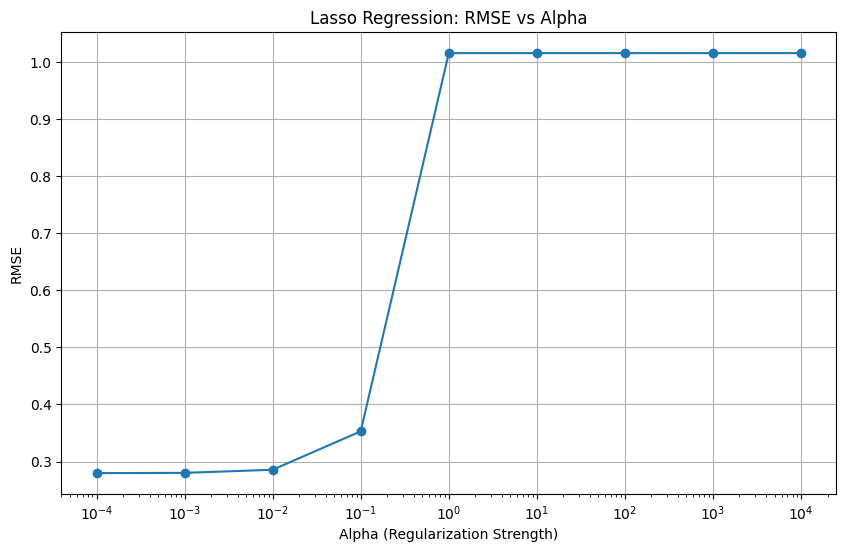

In [15]:
alphas = np.logspace(-4, 4, 9)

rmse_values = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    y_pred = lasso_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, rmse_values, marker='o')
plt.title('Lasso Regression: RMSE vs Alpha')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('RMSE')
plt.grid()
plt.show()


In [18]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print("Lasso Regression - Mean Absolute Error:", mae)
print("Lasso Regression - Mean Squared Error:", mse)
print("Lasso Regression - Root Mean Squared Error:", rmse)


mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
rmse_not_scaled = np.sqrt(mse_not_scaled)
print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


Lasso Regression - Mean Absolute Error: 0.19591031827064026
Lasso Regression - Mean Squared Error: 0.08152195726071364
Lasso Regression - Root Mean Squared Error: 0.2855205023474035


Mean Absolute Error: 22651.022086328725
Mean Squared Error: 1089771848.6040826
Root Mean Squared Error: 33011.69260434979


In [19]:
lasso_coefficients = lasso_model.coef_

print("Lasso Coefficients:")
for feature, coefficient in zip(train_data.columns, lasso_coefficients):
    print(f"{feature}: {coefficient}")


Lasso Coefficients:
longitude: -0.0
latitude: 0.0
housing_median_age: 0.02366926033949611
total_rooms: 0.0
total_bedrooms: 0.0
population: -0.0
households: 0.0
median_income: 0.22070282725128668
median_house_value: 0.0032280629623097795
rooms_per_household: 0.0
bedrooms_per_household: -0.0
population_per_household: -0.023152206611070456
bedrooms_to_rooms: 0.37178862227154563
house_value_income_ratio: 0.26126732462459973
log_median_income: 0.4404188992803657
neighborhood_median_value: -0.004081554232444009
age_new: 0.0
age_moderate: 0.0


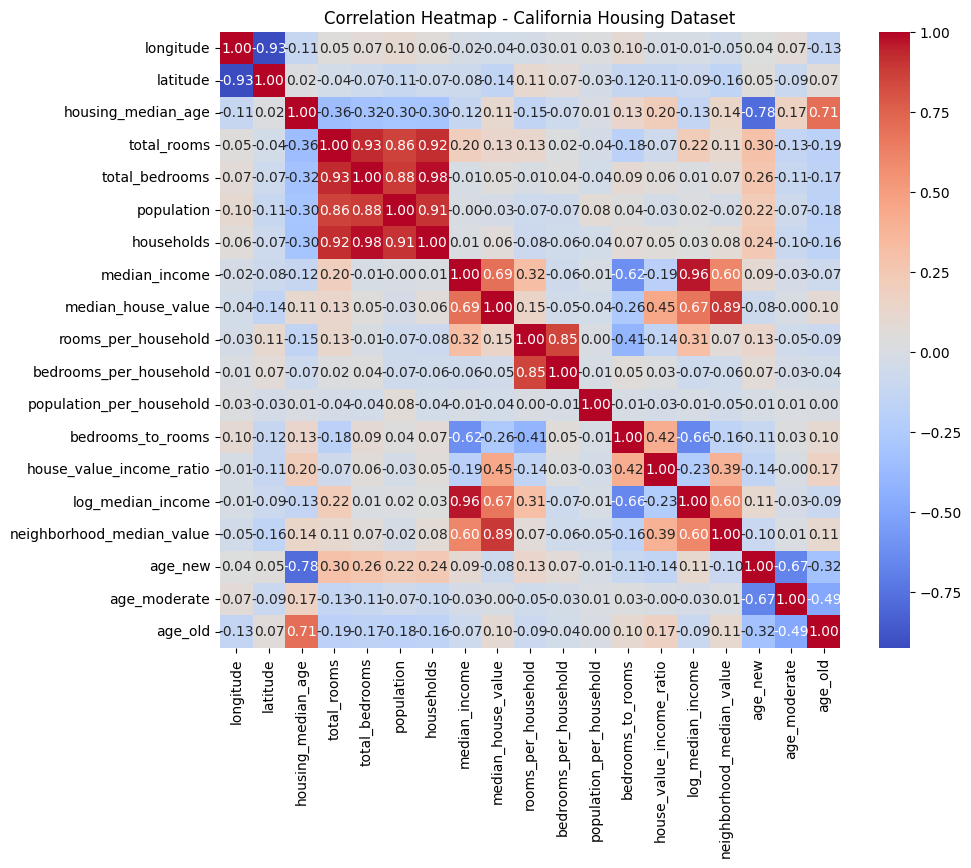

In [20]:
correlation_matrix = train_data.corr()

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - California Housing Dataset")
plt.show()

# Regression Trees

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
rmse_not_scaled = np.sqrt(mse_not_scaled)
print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


Mean Absolute Error: 0.06331370933400852
Mean Squared Error: 0.01859747976153291
Root Mean Squared Error: 0.136372577014343


Mean Absolute Error: 7320.289411764721
Mean Squared Error: 248607989.55411777
Root Mean Squared Error: 15767.307619061594


# Bagging Trees

In [23]:
from sklearn.ensemble import BaggingRegressor

base_model = DecisionTreeRegressor()

bagging_model = BaggingRegressor(base_model, n_estimators=10, random_state=42)

bagging_model.fit(X_train, y_train)

y_pred = bagging_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
rmse_not_scaled = np.sqrt(mse_not_scaled)
print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


/Users/abughdaryan/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Mean Absolute Error: 0.04503110480080884
Mean Squared Error: 0.01333438362120941
Root Mean Squared Error: 0.11547460162827759


Mean Absolute Error: 5206.466705882355
Mean Squared Error: 178251803.28299412
Root Mean Squared Error: 13351.097456126749


# Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


mae_not_scaled = mean_absolute_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
mse_not_scaled = mean_squared_error(y_val_unscaled, target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
rmse_not_scaled = np.sqrt(mse_not_scaled)
print('\n')

print("Mean Absolute Error:", mae_not_scaled)
print("Mean Squared Error:", mse_not_scaled)
print("Root Mean Squared Error:", rmse_not_scaled)


/Users/abughdaryan/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Absolute Error: 0.03756252067348859
Mean Squared Error: 0.01205761620491689
Root Mean Squared Error: 0.10980717738343378


Mean Absolute Error: 4342.953923529394
Mean Squared Error: 161184190.65145734
Root Mean Squared Error: 12695.8335941937
